# Geometric Problems

**Originally Contributed by**: Arpit Bhatia

These problems in this tutorial are drawn from Chapter 8 of the book 
Convex Optimization by Boyd and Vandenberghe[[1]](#c1)

In [1]:
using JuMP
using Ipopt
using Random
# for plots
using Gadfly
using DataFrames

Random.seed!(1234);

┌ Info: Recompiling stale cache file /home/mbesancon/.julia/compiled/v1.0/Gadfly/DvECm.ji for Gadfly [c91e804a-d5a3-530f-b6f0-dfbca275c004]
└ @ Base loading.jl:1190


## Euclidean Projection on a Hyperplane
For a given point $x_{0}$ and a set $C$, we refer to any point $z \in C$ 
which is closest to $x_{0}$ as a projection of $x_{0}$ on $C$. 
The projection of a point $x_{0}$ on a hyperplane $C = \{x | a' \cdot x = b\}$ is given by

$$
\begin{align*}
\min && ||x - x_{0}|| \\
s.t. && a' \cdot x = b 
\end{align*}
$$

In [2]:
x = rand(10)
a = rand(10)
b = rand()

projection = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0))
@variable(projection, x0[1:10])
@objective(projection, Min, sum((x - x0) .* (x - x0))) # We minimize the square of the distance here
@constraint(projection, x0' * a == b)                  # Point must lie on the hyperplane

optimize!(projection)
@show objective_value(projection);
@show value.(x0);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

objective_value(projection) = 0.5495962663047205
value.(x0) = [0.312464, 0.762118, 0.537741, 0.0496227, 0.516585, 0.805888, 0.0821686, 0.0190398, 0.222537, 0.218135]


## Euclidean Distance Between Polyhedra
Given two polyhedra $C = \{x | A_{1} \cdot x \leq b1\}$ and $D = \{x | A_{2} \cdot x \leq b_{2}\}$, 
the distance between them is the optimal value of the problem:

$$
\begin{align*}
\min && ||x - y|| \\
s.t. && A_{1} \cdot x \leq b_{1} \\
&& A_{2} \cdot y \leq b_{2} 
\end{align*}
$$

In [3]:
A_1 = rand(10, 10)
A_2 = rand(10, 10)
b_1 = rand(10)
b_2 = rand(10)

polyhedra_distance = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0))
@variable(polyhedra_distance, x[1:10])                       # Point closest on the first polyhedron
@variable(polyhedra_distance, y[1:10])                       # Point closest on the second polyhedron
@objective(polyhedra_distance, Min, sum((x - y) .* (x - y))) # We minimize the square of the distance here as above
@constraint(polyhedra_distance, A_1 * x .<= b_1)             # Point x must lie on the first polyhedron
@constraint(polyhedra_distance, A_2 * y .<= b_2)             # Point y must lie on the second polyhedron

optimize!(polyhedra_distance)
@show objective_value(polyhedra_distance);

objective_value(polyhedra_distance) = 5.204170427930421e-18


## Linear Placement Problem
We have $N$ points in $\mathbb{R}^2$, and a list of pairs of points that must be connected by links. 
The positions of some of the $N$ points are fixed; our task is to determine the positions of the remaining points, 
i.e., to place the remaining points. The objective is to place the points so that the distance between the links is minimized, 
i.e. our objective is:

$$
\begin{align*}
\min && \sum_{(i,j) \in A}||p_{i} - p_{j}|| 
\end{align*}
$$

In [4]:
fixed = [ 1   1  -1 -1    1   -1  -0.2  0.1;         # coordinates of fixed points
          1  -1  -1  1 -0.5 -0.2    -1    1]

M = size(fixed,2)                                    # number of fixed points
N = 6                                                # number of free points

A = [ 1  0  0 -1  0  0    0  0  0  0  0  0  0  0;    # Matrix on links
      1  0 -1  0  0  0    0  0  0  0  0  0  0  0;
      1  0  0  0 -1  0    0  0  0  0  0  0  0  0;
      1  0  0  0  0  0   -1  0  0  0  0  0  0  0;
      1  0  0  0  0  0    0 -1  0  0  0  0  0  0;
      1  0  0  0  0  0    0  0  0  0 -1  0  0  0;
      1  0  0  0  0  0    0  0  0  0  0  0  0 -1;
      0  1 -1  0  0  0    0  0  0  0  0  0  0  0;
      0  1  0 -1  0  0    0  0  0  0  0  0  0  0;
      0  1  0  0  0 -1    0  0  0  0  0  0  0  0;
      0  1  0  0  0  0    0 -1  0  0  0  0  0  0;
      0  1  0  0  0  0    0  0 -1  0  0  0  0  0;
      0  1  0  0  0  0    0  0  0  0  0  0 -1  0;
      0  0  1 -1  0  0    0  0  0  0  0  0  0  0;
      0  0  1  0  0  0    0 -1  0  0  0  0  0  0;
      0  0  1  0  0  0    0  0  0  0 -1  0  0  0;
      0  0  0  1 -1  0    0  0  0  0  0  0  0  0;
      0  0  0  1  0  0    0  0 -1  0  0  0  0  0;
      0  0  0  1  0  0    0  0  0 -1  0  0  0  0;
      0  0  0  1  0  0    0  0  0  0  0 -1  0  0;
      0  0  0  1  0  0    0  0  0  0  0 -1  0  0;        
      0  0  0  0  1 -1    0  0  0  0  0  0  0  0;
      0  0  0  0  1  0   -1  0  0  0  0  0  0  0;
      0  0  0  0  1  0    0  0  0 -1  0  0  0  0;
      0  0  0  0  1  0    0  0  0  0  0  0  0 -1;
      0  0  0  0  0  1    0  0 -1  0  0  0  0  0;
      0  0  0  0  0  1    0  0  0  0 -1  0  0  0;]

placement = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0))
@variable(placement, p[1:M + N, 1:2])                     # A variable array for the coordinates of each point
@constraint(placement, p[N + 1:N + M, :] .== fixed')      # We had a constraint for the fixed points
dist = A * p                                         # Matrix of differences between coordinates of 2 points with a link
@objective(placement, Min, sum(dist .* dist))            # We minimize the sum of the square of the distances

optimize!(placement)
@show value.(p);
@show objective_value(placement);

value.(p) = [0.44791 0.0468982; -0.0319353 -0.670614; 0.404336 -0.451308; -0.394295 -0.132825; 0.025327 0.412421; -0.00165206 -0.439548; 1.0 1.0; 1.0 -1.0; -1.0 -1.0; -1.0 1.0; 1.0 -0.5; -1.0 -0.2; -0.2 -1.0; 0.1 1.0]
objective_value(placement) = 20.44474039109911


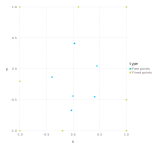

In [5]:
# Plotting the points
df = DataFrame()
df.x = value.(p)[:,1]
df.y = value.(p)[:,2]
df.type = vcat(fill("Free points", N), fill("Fixed points", M))
plt = plot(df, x = "x", y = "y", color = "type", Geom.point)
draw(SVG(6inch, 6inch), plt)

## Floor Planning
A floor planning problem consists of rectangles or boxes aligned with the axes which must be placed, 
within some limits such that they do not overlap. The objective is usually to minimize the size 
(e.g., area, volume, perimeter) of the bounding box, which is the smallest box that contains the boxes to be configured and placed.
We model this problem as follows:

We have N boxes $B_{1}, . . . , B_{N}$ that are to be configured and placed in a rectangle with width $W$ and height $H$, 
and lower left corner at the position $(0, 0)$. The geometry and position of the $i$th box is specified by 
its width $w_{i}$ and height $h_{i}$, and the coordinates $(x_{i}, y_{i})$ of its lower left corner.

The variables in the problem are $x_{i}, y_{i}, w_{i}, h_{i}$ for $i=1, \ldots, 
N,$ and the width $W$ and height $H$ of the bounding rectangle. In all floor planning problems, 
we require that the cells lie inside the bounding rectangle, $i . e .$

$$
x_{i} \geq 0, \quad y_{i} \geq 0, \quad x_{i}+w_{i} \leq W, \quad y_{i}+h_{i} \leq H, \quad i=1, \ldots, N
$$

We also require that the cells do not overlap, except possibly on their boundaries, i.e.

$$
x_{i}+w_{i} \leq x_{j} \quad \text{or} \quad x_{j}+w_{j} \leq x_{i} \quad \text{or} \quad y_{i}+h_{j} \leq y_{j} \quad \text{or} \quad y_{j}+h_{i} \leq y_{i}
$$

In [6]:
n = 5;

Amin = [                                        # We'll try this problem with 4 times with different minimum area constraints
100 100 100 100 100;
 20  50  80 150 200;
180  80  80  80  80;
 20 150  20 200 110]

r = 1

figs=[]

for i = 1:4
    A = Amin[i, :]

    floor_planning = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0))

    @variables(floor_planning, begin
        x[1:n] >= r
        y[1:n] >= r
        w[1:n] >= 0
        h[1:n] >= 0
        W
        H
    end)

    @constraints(floor_planning, begin
        x[5] + w[5] + r <= W    # No rectangles at the right of Rectangle 5
        x[1] + w[1] + r <= x[3] # Rectangle 1 is at the left of Rectangle 3
        x[2] + w[2] + r <= x[3] # Rectangle 2 is at the left of Rectangle 3
        x[3] + w[3] + r <= x[5] # Rectangle 3 is at the left of Rectangle 5
        x[4] + w[4] + r <= x[5] # Rectangle 4 is at the left of Rectangle 5
        y[4] + h[4] + r <= H    # No rectangles on top of Rectangle 4
        y[5] + h[5] + r <= H    # No rectangles on top of Rectangle 5
        y[2] + h[2] + r <= y[1] # Rectangle 2 is below Rectangle 1
        y[1] + h[1] + r <= y[4] # Rectangle 1 is below Rectangle 4
        y[3] + h[3] + r <= y[4] # Rectangle 3 is below Rectangle 4
        w .<= 5*h               # Aspect ratio constraint
        h .<= 5*w               # Aspect ratio constraint
        A .<= h .*  w           # Area constraint
    end)

    @objective(floor_planning, Min, W + H)

    optimize!(floor_planning)

    @show objective_value(floor_planning);

    D = DataFrame(x = value.(x), y = value.(y), x2 = value.(x) .+ value.(w), y2 = value.(y) .+ value.(h))
    plt = plot(D, xmin = :x, ymin = :y, xmax = :x2, ymax = :y2, Geom.rect)
    push!(figs, plt)
end

objective_value(floor_planning) = 51.93446154361733
objective_value(floor_planning) = 51.1562218755639
objective_value(floor_planning) = 52.669203332919835
objective_value(floor_planning) = 52.54574619621182


In [7]:
draw(SVG(6inch, 6inch), vstack(hstack(figs[1], figs[2]), hstack(figs[3], figs[4])))

### References
<a id='c1'></a>
1. Boyd, S., & Vandenberghe, L. (2004). Convex Optimization. Cambridge: Cambridge University Press. doi:10.1017/CBO9780511804441